In [3]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import os.path as op
import sys
sys.path.append("../")

import nibabel as nib
from nilearn.surface import vol_to_surf
from nilearn.plotting import plot_surf_roi

from src import regmod
from src import utils
from src import solver

import h5py

def get_aggprop(h5dict: h5py._hl.files.File, property: str):
    """
    Get the bundles statistics on whole brain level from the HDF5 file.

    Parameters
    ----------
    h5dict : h5py._hl.files.File 
        The opened HDF5 file.
    property : str
        The property to extract from the HDF5 file.

    Returns
    -------
    ret : np.arrasy
        The array containing the requested property values.
    """

    try:
        ret = np.array(h5dict.get("matrices").get(property))
    except:
        print("Not valid property OR h5 not opened")
    return ret

# Loading the data

In [2]:
import os

sinergia_plots_loc = "../figures/sinergia_ghent"

save_figures = False

if save_figures:
    os.makedirs(sinergia_plots_loc, exist_ok=True)

In [4]:
def load_ftract(path_to_ftract:str) -> np.ndarray:
    with open(op.join(path_to_ftract, 'peak_delay__median.txt')) as f:
        text = f.readlines()

    ftract_delays = []
    for t in text[8:]:
        ftract_delays.append(t.split(' '))
    ftract_delays = np.array(ftract_delays).astype(float)
    ftract_delays = np.nan_to_num(ftract_delays[:-1, :-1])
    ftract_delays -= np.diag(np.diag(ftract_delays))

    return ftract_delays

In [ ]:
path_to_ressources = "../resources"

delay_max = 400

path_to_ftract = f"/Users/acionca/data/F-TRACT-090624/{delay_max}" #/probability.txt.gz"

ftract_prob = utils.load(op.join(path_to_ressources, f"adj_probability_ftract-d{delay_max}.pkl"))
ftract_prob = ftract_prob[:83, :83]

ftract_delays = load_ftract(path_to_ftract=path_to_ftract)

#e_delay_filename = "effective_delays-f0.05b0.4-L1-1subopt.pkl"
e_delay_filename = "alpha_varying.pkl"
e_delay_filename = "delta_varying.pkl"
alphas, delays_and_loss = utils.load(op.join(path_to_ressources, e_delay_filename))

print(alphas)

select_alpha = 51

delay_vectors = [delays_and_loss[a][0] for a in alphas]
losses = [delays_and_loss[a][1] for a in alphas]

effective_vector, loss = delays_and_loss[select_alpha]
effective_delays = utils.add_diagonal_entries(effective_vector.reshape((ftract_delays.shape[0], ftract_delays.shape[0]-1)))

# No Brainstem:
ftract_delays = ftract_delays[:-1][:, :-1]
effective_delays = effective_delays[:-1][:, :-1]

In [ ]:
plt.plot(alphas, losses)

In [6]:
with open('/Users/acionca/data/F-TRACT-090624/Lausanne2008-33.txt') as f:
#with open(delay_file) as f:
    array2 = f.readlines()[1:]

array2 = [regionname.replace('.','-').lower().strip() for k, regionname in enumerate(array2)]
for sidx, region in enumerate(array2):
    if 'right' in region:
        array2[sidx] = region.replace('right','rh')
    if 'left' in region:
        array2[sidx] = region.replace('left','lh')

ftract_labels = array2[:-1]
ftract_groups = np.ones_like(ftract_labels, dtype=int)
group_to_lab = {1:"ctx", 2:"sub", 3:"brainstem"}

is_cortical = [lab.split("-")[0] == "ctx" for lab in ftract_labels]
ftract_groups[np.logical_not(is_cortical)] = 2
ftract_groups[-1] = 3

# No Brainstem:
ftract_labels = ftract_labels[:-1]
ftract_groups = ftract_groups[:-1]

#ftract_hemi = np.zeros_like(ftract_groups)
#hemi_to_lab = {1:"lh", 2:"rh"}
#lab_to_hemi = {"lh":1, "rh":2}
#hemi = [lab.split("-")[1] for lab in ftract_labels]
#ftract_hemi[is_cortical] = [lab_to_hemi[lab] for i, lab in enumerate(hemi) if is_cortical[i]]
#ftract_hemi[ftract_hemi == 0] = [lab_to_hemi[lab.split("-")[0]] for i, lab in enumerate(ftract_labels) if not is_cortical[i]]

# Computing connectome (degree) asymmetry

In [ ]:
from seaborn import kdeplot

# degrees vectors are [in-degree, out-degree]
effective_degrees = np.array([effective_delays.sum(axis=0), effective_delays.sum(axis=1)])

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

for deg, ax in zip(effective_degrees, axes):
    kdeplot(deg, ax=ax, clip=(0, 1e10), bw_adjust=0.8, lw=4, label="Effective delay", zorder=1)

for d in [50, 100, 200, 400]:
    f_delays = load_ftract(path_to_ftract=f"/Users/acionca/data/F-TRACT-090624/{d}")
    f_degrees = np.array([f_delays.sum(axis=0), f_delays.sum(axis=1)])


    for deg, ax in zip(f_degrees, axes):
        kdeplot(deg, ax=ax, clip=(0, 1e10), bw_adjust=0.8, lw=2, label=f"F-Tract ({d})", zorder=0)
        #ax.hist(deg, bins=np.linspace(0, 10000, 200), zorder=0)

axes[0].set_xlabel("In-degree")
axes[0].set_xlabel("In-degree")
axes[1].set_xlabel("Out-degree")
axes[1].set_xlabel("Out-degree")

for ax in axes:
    ax.legend()
    ax.set_ylabel("Distribution")
    ax.set_yticks([])

if save_figures:
    fig.savefig(op.join(sinergia_plots_loc, f"Validate-DegreeComparison-v00.png"), dpi=100)

In [ ]:
from seaborn import kdeplot

# degrees vectors are [in-degree, out-degree]
effective_degrees = np.array([effective_delays.sum(axis=0), effective_delays.sum(axis=1)])

fig, axes = plt.subplots(ncols=4, figsize=(20, 5), sharex=True, sharey=True, gridspec_kw={"wspace":0})

ratio = effective_degrees[1]/effective_degrees[0]

#kdeplot(ratio, ax=axes, clip=(0, 1e10), bw_adjust=0.8, lw=4, label="Effective delay", zorder=1)

for i, d in enumerate([50, 100, 200, 400]):
    f_delays = load_ftract(path_to_ftract=f"/Users/acionca/data/F-TRACT-090624/{d}")
    f_degrees = np.array([f_delays.sum(axis=0), f_delays.sum(axis=1)])

    ratio_d = f_degrees[1]/f_degrees[0]
    ratio_d = ratio_d[:-1]

    axes[i].scatter(ratio, ratio_d, s=70, edgecolor="w")
    
    #kdeplot(ratio_d, ax=axes, clip=(0, 1e10), bw_adjust=0.8, lw=2, label=f"F-Tract ({d})", zorder=0)

    axes[i].plot([ratio.min(), ratio.max()], [ratio.min(), ratio.max()], "k--", lw=2, zorder=0)

    axes[i].set_title(f"peak ${d}$")

axes[0].set_ylabel("F-Tract ratio")

for ax in axes:
    ax.set_xlabel("Effective delay ratio")

fig.suptitle("Out-/In-degree ratio")
if save_figures:
    fig.savefig(op.join(sinergia_plots_loc, f"Validate-DegreeRatio-delta{select_alpha}.png"), dpi=100)

In [ ]:
# degrees vectors are [in-degree, out-degree]
ftract_degrees = np.array([ftract_delays.sum(axis=0), ftract_delays.sum(axis=1)])
effective_degrees = np.array([effective_delays.sum(axis=0), effective_delays.sum(axis=1)])

fig, axes = plt.subplots(ncols=2, figsize=(11, 5), gridspec_kw={"wspace":0.25})

features = ["in-degree", "out-degree"]
for i, (x_val, y_val) in enumerate(zip([ftract_degrees[0], ftract_degrees[1]],
                                      [effective_degrees[0], effective_degrees[1]])):

    x_val = np.nan_to_num(x_val, nan=0.5, posinf=0.5, neginf=0.5)
    y_val = np.nan_to_num(y_val, nan=0.5, posinf=0.5, neginf=0.5)
    #axes[i].scatter(x_val, y_val, c=ftract_groups, cmap="Set1", s=80, alpha=1, edgecolor="w", lw=1, vmax=10)
    axes[i].scatter(x_val, y_val, s=80, alpha=1, edgecolor="w", lw=1, vmax=10)
    
    axes[i].plot([y_val.min(), y_val.max()],
                 [y_val.min(), y_val.max()], "k--", lw=2, zorder=0)
        
    if i < 3:
        axes[i].plot([y_val.min(), y_val.max()*2],
                     [y_val.min(), y_val.max()], "k:", lw=2, zorder=0)
    
    selected_labels = ["rh-amygdala", "lh-amygdala",]
    for j, lab in enumerate(ftract_labels):
        #if lab in selected_labels:
        if False:
                axes[i].text(x_val[j], y_val[j], lab)

    axes[i].set_title(features[i])
    axes[i].set_xlabel("F-Tract delays " + features[i])
    axes[i].set_ylabel("Effective delays " + features[i])

fig.suptitle(f"Comparison of F-Tract (peak{delay_max}) and effective delays")
if save_figures:
    fig.savefig(op.join(sinergia_plots_loc, f"Validate-DegreeComparison-v00.png"), dpi=100)

In [ ]:
ftract_asymmetry = ftract_degrees[1] - ftract_degrees[0]
effective_asymmetry = effective_degrees[1] - effective_degrees[0]

ftract_asymmetry_rate = ftract_degrees[1]/(ftract_degrees[0]+ftract_degrees[1])
effective_asymmetry_rate = effective_degrees[1]/(effective_degrees[0]+effective_degrees[1])

fig, axes = plt.subplots(ncols=2, figsize=(11, 5), gridspec_kw={"wspace":0.25})

#titles = ["$d_{{out}}-d_{{in}}$", "$\frac{{d_{{out}}}}{{d_{{out}}+d_{{in}}}}$"]
titles = ["Degree difference", "Out-degree ratio"]
features = ["asymmetry (diff)", "asymmetry (rate)"]
for i, (x_val, y_val) in enumerate(zip([ftract_asymmetry, ftract_asymmetry_rate],
                                      [effective_asymmetry, effective_asymmetry_rate])):

    x_val = np.nan_to_num(x_val, nan=0.5, posinf=0.5, neginf=0.5)
    y_val = np.nan_to_num(y_val, nan=0.5, posinf=0.5, neginf=0.5)
    axes[i].scatter(x_val, y_val, c=ftract_groups, cmap="Set1", s=80, alpha=1, edgecolor="w", lw=1, vmax=10)
    
    axes[i].plot([y_val.min(), y_val.max()],
                 [y_val.min(), y_val.max()], "k--", lw=2, zorder=0)
        
    if i < 1:
        axes[i].plot([y_val.min(), y_val.max()*2],
                     [y_val.min(), y_val.max()], "k:", lw=2, zorder=0)
    #else:
    #    axes[i].plot([y_val.min(), y_val.max()],
    #                 [0.5]*2, "k:", lw=2, zorder=0)
    #    axes[i].plot([0.5]*2,
    #                 [y_val.min(), y_val.max()], "k:", lw=2, zorder=0)
    
    selected_labels = ["ctx-rh-frontalpole", "ctx-lh-frontalpole",
                       "rh-pallidum", "lh-pallidum"]
    for j, lab in enumerate(ftract_labels):
        #if lab in selected_labels:
        if False:
                axes[i].text(x_val[j], y_val[j], lab)

    axes[i].set_title(titles[i])
    axes[i].set_xlabel("F-Tract delays " + features[i])
    axes[i].set_ylabel("Effective delays " + features[i])

fig.suptitle(f"Comparison of F-Tract (peak{delay_max}) and effective delays")

if save_figures:
    fig.savefig(op.join(sinergia_plots_loc, f"Validate-SymmetryComparison-v00.png"), dpi=100)

# Investigating the relationship with bundle average lengths

#### EXAMPLE OF HOW TO GET FIBER LENGTH (for the probability we use `consistency` so need to change that to `length`)

In [132]:
# data_path = "/Users/acionca/data"
data_path = "../../atlas_data/"

region_file = op.join(data_path, f'F-TRACT-090624/Lausanne2008-33.txt')
scale = 1
# connFilename = op.join(data_path, "atlas_data", f'fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5')
connFilename = op.join(data_path, f'fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5')
hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))

gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = gmregions_names.shape[0]
length_view = get_aggprop(hf, 'length')

array1 = gmregions_names
array1 = [a.decode('utf-8').lower() for a in array1]

with open(region_file) as f:
    array2 = f.readlines()

array2 = [regionname.replace('.','-').lower().strip() for k, regionname in enumerate(array2)]
for sidx, region in enumerate(array2):
    if 'right' in region:
        array2[sidx] = region.replace('right','rh')
    if 'left' in region:
        array2[sidx] = region.replace('left','lh')

In [133]:
match_indexes = np.zeros(len(array2)) - 1
for k in range(len(array2)):
    for sidx, searchname in enumerate(array1):
        if array2[k] in searchname:
            match_indexes[k] = sidx
        if 'lh-accumbens-area' in array2[k]:
            if 'lh-accumbens' in searchname:
                match_indexes[k] = sidx
        if 'rh-accumbens-area' in array2[k]:
            if 'rh-accumbens' in searchname:
                match_indexes[k] = sidx
                
rightth = np.where(['thal' in tmp for tmp in array1])[0][:7]
leftth = np.where(['thal' in tmp for tmp in array1])[0][7:]

In [134]:
struct_length = length_view

max_delay = 400
proba_file = op.join(data_path, f'F-TRACT-090624/{max_delay}/probability.txt.gz')

proba_array = np.genfromtxt(proba_file, delimiter=' ')
proba_array = np.array(proba_array).astype(float)

fibers_array = np.zeros_like(proba_array)
for ridx in range(len(fibers_array)):
    for cidx in range(len(fibers_array)):
        
        if (ridx == 83) or (cidx == 83):
            fibers_array[ridx, cidx] = np.nan
        else:
            if ridx == 34 and cidx == 34: fibers_array[ridx, cidx] = struct_length[rightth][:, rightth].mean()
            elif ridx == 34 and cidx == 75: fibers_array[ridx, cidx] = struct_length[rightth][:, rightth].mean()
            elif ridx == 75 and cidx == 34: fibers_array[ridx, cidx] = struct_length[rightth][:, rightth].mean()
            elif ridx == 75 and cidx == 75: fibers_array[ridx, cidx] = struct_length[rightth][:, rightth].mean()
            else:
                fibers_array[ridx, cidx] = struct_length[int(match_indexes[ridx]), int(match_indexes[cidx])]

# NOTE: fibers_array is an array re-aligned by regions to match f-tract, matrix of fiber lengths
fibers_array = np.nan_to_num(fibers_array)[:83, :83]

In [137]:
# Loading conductance delays
# path_to_ftract = f"/Users/acionca/data/F-TRACT-090624/{delay_max}"
delays = [50, 100, 200, 400]
ftract_delays = {}
for delay in delays:
    path_to_ftract = op.join(data_path, f'F-TRACT-090624/{delay}/')
    ftract_delays[delay] = load_ftract(path_to_ftract=path_to_ftract)

# Loading effective delays
alpha_tmp = utils.load("../resources/alpha_varying.pkl")
alpha_varying = {}
for (u,v) in alpha_tmp[1].items():
    alpha_varying[u] = utils.add_diagonal_entries(v[0].reshape(fibers_array.shape[0], fibers_array.shape[1]-1))

delta_tmp = utils.load("../resources/delta_varying.pkl")
delta_varying = {}
for (u,v) in delta_tmp[1].items():
    delta_varying[u] = utils.add_diagonal_entries(v[0].reshape(fibers_array.shape[0], fibers_array.shape[1]-1))

opt_delta = utils.load("../resources/joint_optim_delta.pkl")
opt_delta = utils.add_diagonal_entries(opt_delta[0].reshape(fibers_array.shape[0], fibers_array.shape[1]-1))

opt_alphadelta = utils.load("../resources/joint_optim_alpha-delta.pkl")
opt_alphadelta = utils.add_diagonal_entries(opt_alphadelta[0].reshape(fibers_array.shape[0], fibers_array.shape[1]-1))

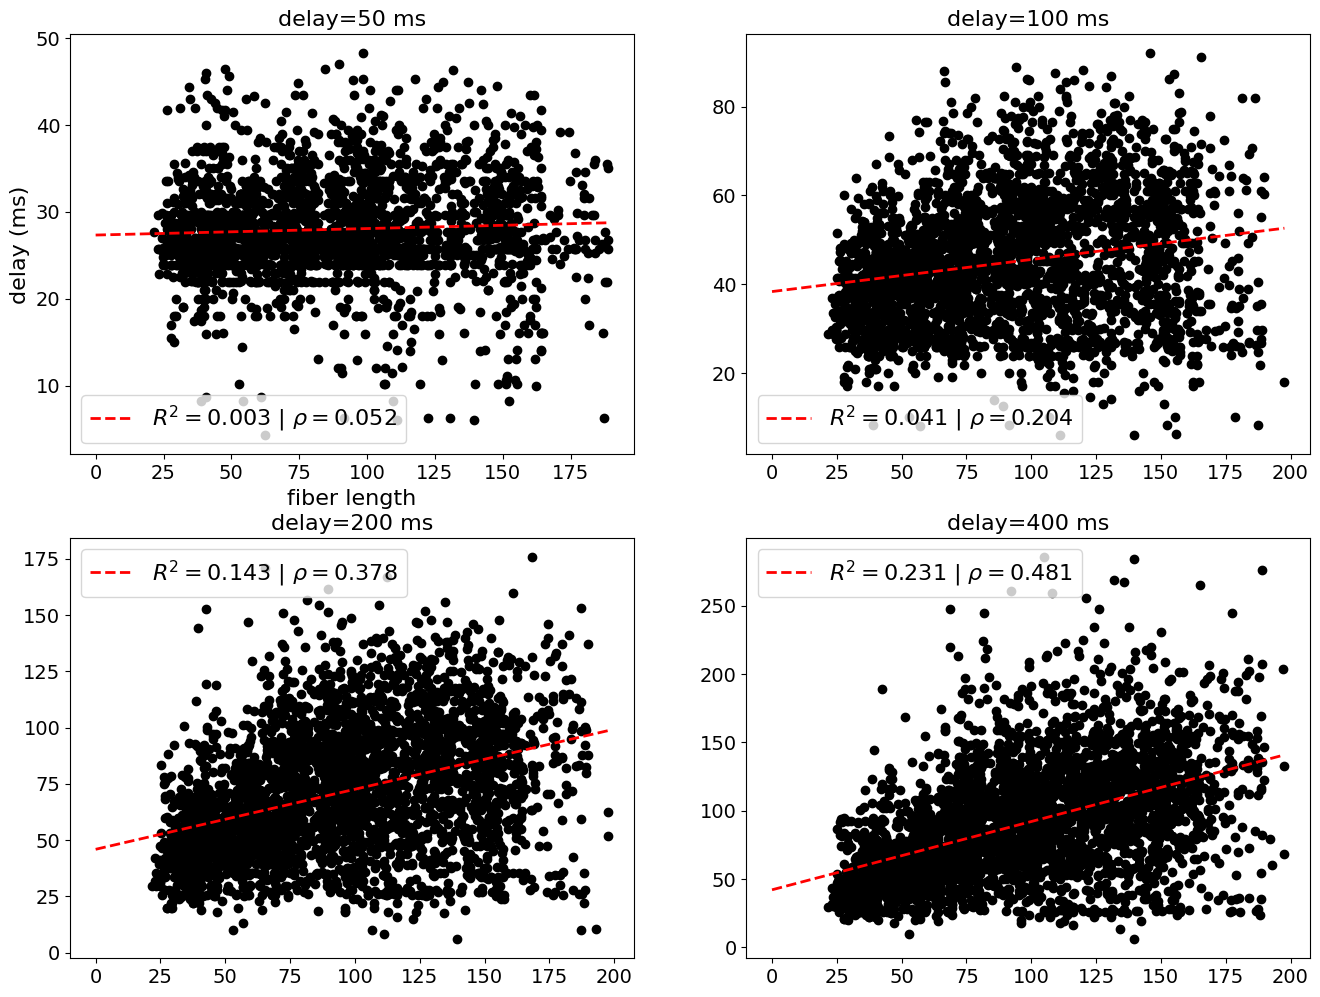

In [168]:
from sklearn.linear_model import LinearRegression
from scipy import stats

def joint_mask(arr1, arr2):
    return np.logical_and((arr1 > 0), (arr2 > 0))

fig, ax = plt.subplots(2,2, figsize=(16,12))
for k in range(4):
    r, c = k//2, k%2
    mask = np.logical_and((ftract_delays[delays[k]] > 0), (fibers_array > 0))

    y = ftract_delays[delays[k]][mask]
    x = fibers_array[mask]

    model = LinearRegression()
    model.fit(x.reshape(-1,1), y)
    r_squared = model.score(x.reshape(-1,1), y)
    corr = stats.pearsonr(x, y)[0]
    
    ax[r, c].scatter(x, y, color='k')
    ax[r, c].plot([0, x.max()], [model.intercept_, model.intercept_ + x.max() * model.coef_[0]], 
                  linewidth=2, color='r', linestyle='--', 
                  label=rf'$R^2={np.round(r_squared, 3)}$ | $\rho={np.round(corr,3)}$')
    
    ax[r, c].legend(fontsize=16)
    ax[r, c].set_title(f'delay={delays[k]} ms', fontsize=16)
    if (r == 0) and (c == 0):
        ax[r, c].set_xlabel('fiber length', fontsize=16)
        ax[r, c].set_ylabel('delay (ms)', fontsize=16)

    ax[r, c].tick_params(labelsize=14)
    

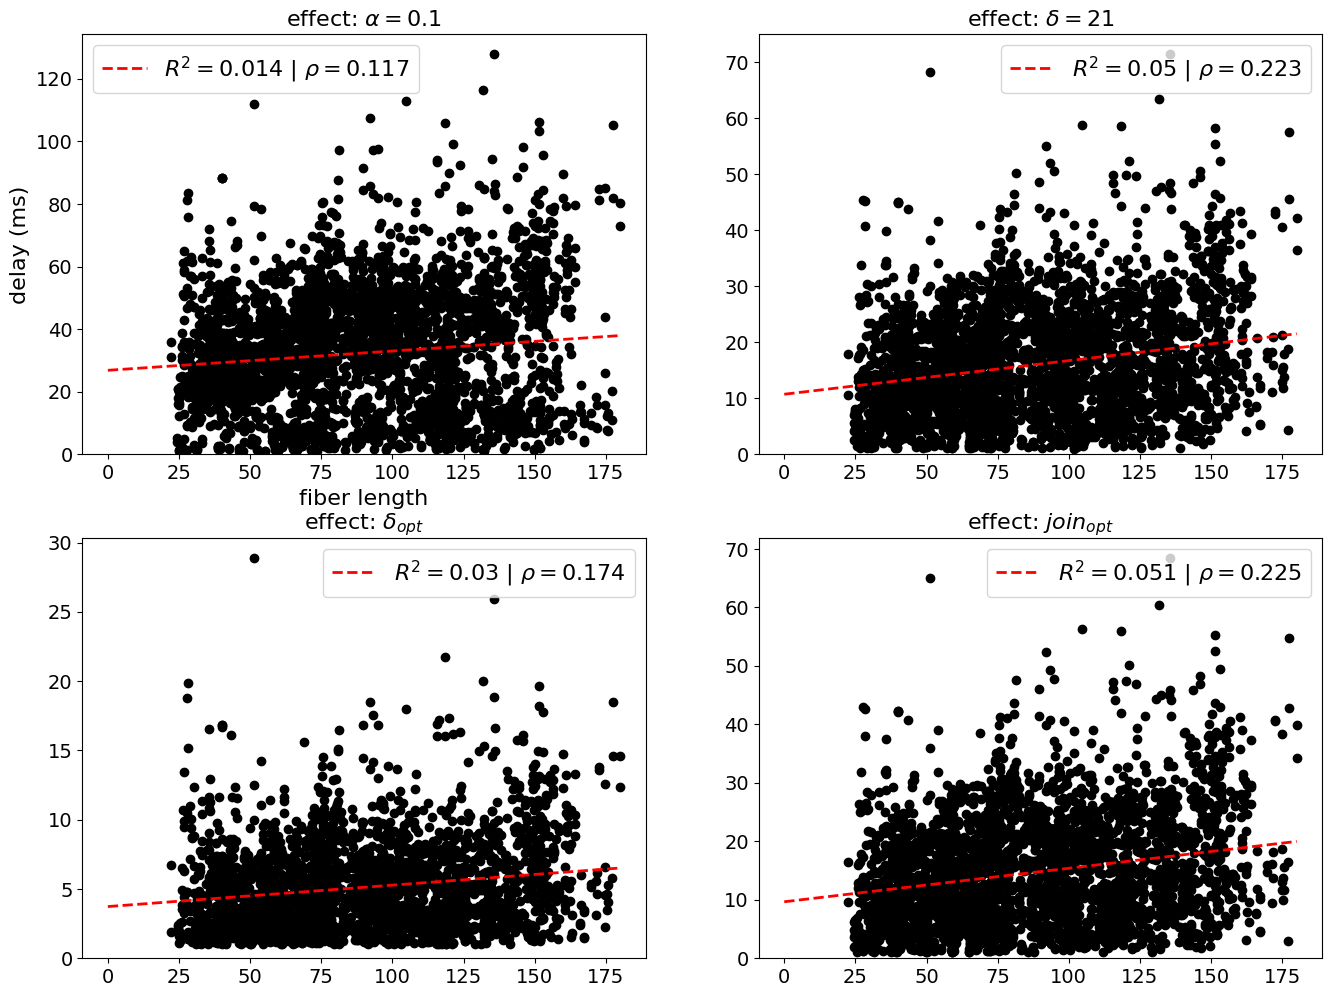

In [169]:
# Some examples to first visualize
eff_delay = [alpha_varying[0.1], delta_varying[21.0], opt_delta, opt_alphadelta]
labels = [rf'$\alpha={0.1}$', rf'$\delta={21}$', r'$\delta_{opt}$', r'$join_{opt}$']

min_delay = 1
fig, ax = plt.subplots(2,2, figsize=(16,12))
for k in range(4):
    r, c = k//2, k%2
    mask = np.logical_and((eff_delay[k] > min_delay), (fibers_array > 0))
    
    y = eff_delay[k][mask]
    x = fibers_array[mask]

    model = LinearRegression()
    model.fit(x.reshape(-1,1), y)
    r_squared = model.score(x.reshape(-1,1), y)
    corr = stats.pearsonr(x, y)[0]
    
    ax[r, c].scatter(x, y, color='k')
    ax[r, c].plot([0, x.max()], [model.intercept_, model.intercept_ + x.max() * model.coef_[0]], 
                  linewidth=2, color='r', linestyle='--', 
                  label=rf'$R^2={np.round(r_squared, 3)}$ | $\rho={np.round(corr,3)}$')
    
    ax[r, c].legend(fontsize=16)
    ax[r, c].set_title(f'effect: {labels[k]}', fontsize=16)
    if (r == 0) and (c == 0):
        ax[r, c].set_xlabel('fiber length', fontsize=16)
        ax[r, c].set_ylabel('delay (ms)', fontsize=16)

    ax[r, c].tick_params(labelsize=14)

    ax[r, c].set_ylim(0,)

## Plotting on the brain (WIP)

Here's a little code snipet to plot statistical images on brain surfaces including the cerebellum.
- First, we load the files to define brain mesh for each hemisphere (in `Test_smth_LH.nv` and `Test_smth_RH.nv`) and save the mesh vertices and faces IDs in separate variables.
- Then we can load any 3D nifti image and convert it to a surface file
- Finally, the second cell shows the image in an interactive window (could be opened in the browser if you remove `renderer=None`)
    - The `showed_plot = ...` part is required otherwise two plots are shown

In [36]:
path_to_mesh = op.join(path_to_ressources, "brainmesh")

# Load the mesh files and store the vertices and faces IDs
all_vertices = []
all_faces = []
for mesh_file in ["Test_smth_LH.nv", "Test_smth_RH.nv"]:
    with open(op.join(path_to_mesh, "Test_smth_RH.nv"), 'r') as f:
        data = f.read().splitlines()
    n_vertices = int(data[0])
    n_faces = int(data[n_vertices + 1])

    all_vertices += [row.split(" ") for row in data[1:n_vertices+1]]
    all_faces += [row.split(" ") for row in data[n_vertices+2:]]

# Convert to Numpy arrays
all_vertices = np.array(all_vertices, dtype=float)
all_faces = np.array(all_faces, dtype=int) - 1

### Load Ftract & Bundle atlases data

In [ ]:
# Load the 3D Nifti image and project it to the surface
path_to_bundle_ROIs = ("/Users/acionca/data/atlas_data/fiber_atlas/yasser_datacomp/maxprob/"+
                       "lausanne2018.scale1.sym.corrected.ctx+subc.maxprob.nii.gz")
path_to_bundle_labels = ("/Users/acionca/data/atlas_data/fiber_atlas/yasser_datacomp/GM_regions_ConnectomeAtlas-Compressed/"+
                         "lausanne2018.scale1.sym.corrected_FreeSurferColorLUT.txt")

with open(path_to_bundle_labels) as f:
    lines = f.readlines()[5:]

all_entries = [l.lower().strip().split(" ") for l in lines]

bundle_lab_id = []
bundle_roi = []
for e in all_entries:
    cleaned_list = [l for l in e if l != ""]
    #print(cleaned_list)
    if (len(cleaned_list) > 0) and (cleaned_list[0] != "#"):
        bundle_lab_id.append(int(cleaned_list[0]))
        bundle_roi.append(cleaned_list[1])
        
#atlas_img = nib.load(op.join(path_to_drive_data, "Yeo_WholeBrain_156.nii"))
atlas_img = nib.load(path_to_bundle_ROIs)
atlas_data = atlas_img.get_fdata()
print(atlas_data.shape, atlas_data.max())

with open('/Users/acionca/data/F-TRACT-090624/Lausanne2008-33.txt') as f:
#with open(delay_file) as f:
    array2 = f.readlines()[1:]

array2 = [regionname.replace('.','-').lower().strip() for k, regionname in enumerate(array2)]
for sidx, region in enumerate(array2):
    if 'right' in region:
        array2[sidx] = region.replace('right','rh')
    if 'left' in region:
        array2[sidx] = region.replace('left','lh')

ftract_labels = array2[:-1]

In [ ]:
ftract_to_bundle = []

for i, f in enumerate(ftract_labels):
    index = np.where([f == b for b in bundle_roi])[0]

    if len(index) > 0:
        ftract_to_bundle.append(index[0])
    else:
        print(f"No match for {f}")

In [26]:
node_signal_name = ""
node_signal = effective_delays.sum(axis=0)


surf_map = atlas_img

In [ ]:
stat_surf = vol_to_surf(surf_map, [all_vertices, all_faces], interpolation="nearest", radius=5)

surf_plot = plot_surf_roi([all_vertices, all_faces], stat_surf, cmap='jet', hemi="left", view="medial", engine='plotly')
showed_plot = surf_plot.show(renderer=None)

# Comparison between d400 and d50

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
# Scatter

#delay100 = 200
for delay100 in [50, 100, 200]:
    path_to_ftract = f"/Users/acionca/data/F-TRACT-090624/{delay100}" #/probability.txt.gz"

    with open(op.join(path_to_ftract, 'peak_delay__median.txt')) as f:
        text = f.readlines()

    d100_delay_mat = []
    for t in text[8:]:
        d100_delay_mat.append(t.split(' '))
    d100_delay_mat = np.array(d100_delay_mat).astype(float)
    d100_delay_mat = np.nan_to_num(d100_delay_mat[:-2, :-2])

    titles =[f"Estimated effective delays $d^*$",
             f"F-Tract",
             "Comparison of both"]
    
    label = f"peak {delay100}"

    for i, (mat1, mat2) in enumerate(zip([ftract_delays, ftract_delays, d100_delay_mat],
                                        [effective_delays, d100_delay_mat, effective_delays])):
        
        if (i == 0) and (delay100 > 50):
            pass
        else:
            axes[i].scatter(mat1, mat2, alpha=.1, s=20, edgecolor="none", label=label)#, vmax=y_ground_mat.max())
        axes[i].plot([effective_delays.min(), effective_delays.max()],
                    [effective_delays.min(), effective_delays.max()], "k--", lw=2)#, vmax=y_ground_mat.max())
        axes[i].plot([effective_delays.min(), effective_delays.max()],
                    [effective_delays.min(), effective_delays.max()//2], "k:", lw=2)#, vmax=y_ground_mat.max())

        axes[i].set_title(titles[i], fontsize=12)
        axes[i].set_xlabel(f"Conduction delays $m$ (peak ${delay_max}$)")
        axes[i].set_ylabel("Estimated effective delays $d^*$")

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

cmap = plt.get_cmap("tab10", 10)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"peak {delay100}", 
                          markerfacecolor=cmap(i), markersize=10, alpha=0.5) for i, delay100 in enumerate([50, 100, 200])]

for ax in axes[1:]:
    ax.legend(handles=legend_elements)

axes[1].set_ylabel(f"Conduction delays (see legend)")
axes[-1].set_xlabel(f"Conduction delays (see legend)")
axes[-1].set_ylabel("Estimated effective delays $d^*$")

if save_figures:
    #fig.savefig(op.join(sinergia_plots_loc, f"Validate-SymmetryComparison-v00.png"), dpi=100)
    fig.savefig(op.join(sinergia_plots_loc, f"Validate-ScatterComp-peak{delay_max}delta{select_alpha}_allDelays.png"), dpi=300)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
# Scatter

#delay100 = 200
for delay100 in [50, 100, 200]:
    path_to_ftract = f"/Users/acionca/data/F-TRACT-090624/{delay100}" #/probability.txt.gz"

    with open(op.join(path_to_ftract, 'peak_delay__median.txt')) as f:
        text = f.readlines()

    d100_delay_mat = []
    for t in text[8:]:
        d100_delay_mat.append(t.split(' '))
    d100_delay_mat = np.array(d100_delay_mat).astype(float)
    d100_delay_mat = np.nan_to_num(d100_delay_mat[:-2, :-2])

    titles =[f"Estimated effective delays $d^*$",
             "Comparison of both"]
    
    label = f"peak {delay100}"

    for i, (mat1, mat2) in enumerate(zip([ftract_delays, d100_delay_mat],
                                        [effective_delays, effective_delays])):
        
        if (i == 0) and (delay100 > 50):
            pass
        else:
            axes[i].scatter(mat1, mat2, alpha=.1, s=20, edgecolor="none", label=label)#, vmax=y_ground_mat.max())
        axes[i].plot([effective_delays.min(), effective_delays.max()],
                    [effective_delays.min(), effective_delays.max()], "k--", lw=2)#, vmax=y_ground_mat.max())
        axes[i].plot([effective_delays.min(), effective_delays.max()],
                    [effective_delays.min(), effective_delays.max()//2], "k:", lw=2)#, vmax=y_ground_mat.max())

        axes[i].set_title(titles[i], fontsize=12)
        axes[i].set_xlabel(f"Conduction delays $m$ (peak ${delay_max}$)")
        axes[i].set_ylabel("Estimated effective delays $d^*$")

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

cmap = plt.get_cmap("tab10", 10)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"peak {delay100}", 
                          markerfacecolor=cmap(i), markersize=10, alpha=0.5) for i, delay100 in enumerate([50, 100, 200])]

for ax in axes[1:]:
    ax.legend(handles=legend_elements)

axes[-1].set_xlabel(f"Conduction delays (see legend)")
axes[-1].set_ylabel("Estimated effective delays $d^*$")
if save_figures:
    #fig.savefig(op.join(sinergia_plots_loc, f"Validate-SymmetryComparison-v00.png"), dpi=100)
    fig.savefig(op.join(sinergia_plots_loc, f"Validate-ScatterComp-peak{delay_max}delta{select_alpha}_allDelays.png"), dpi=300)

# Cross-validation by removing bundles

# Computing the connection speeds